In [64]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
# Set plot style
# plt.style.use('seaborn-whitegrid')
sns.set_context("notebook", font_scale=1.2)

## Define the plot_metrics_and_coefficients function

First, let's define a function similar to the one used in the original pipeline for generating the plots.

In [14]:
results_coefs_factor_analysis_all_patients = pd.read_csv("../pipeline/results/fa_lrlasso_pipeline_apr16/all_patients/results_coefs_factor_analysis_all_patients.csv", index_col=0)
results_metrics_factor_analysis_all_patients = pd.read_csv("../pipeline/results/fa_lrlasso_pipeline_apr16/all_patients/results_metrics_factor_analysis_all_patients.csv")

In [17]:
results_metrics_factor_analysis_all_patients['group'].value_counts()

group
all_samples    20
P01            20
P03            20
P02            20
P05            20
P04            20
P06            20
P11            20
P07            20
P10            20
P12            20
P09            20
P08            20
P13            20
Name: count, dtype: int64

In [91]:
def plot_metrics_and_coefficients(metrics_df, coefs_df, sample_name="all_samples", top_n=10):
    """
    Plot classification metrics and logistic regression coefficient paths.
    
    Parameters:
    - metrics_df: DataFrame containing metrics along the regularization path
    - coefs_df: DataFrame containing coefficients along the regularization path
    - sample_name: Name of the sample to display in the title
    - top_n: Number of top features to plot based on survival frequency
    """
    # Filter metrics for the given sample
    metrics_results = metrics_df[metrics_df['group'] == sample_name]
    
    if metrics_results.empty:
        print(f"No metrics found for sample '{sample_name}'")
        return None
    
    # Step 1: Extract alpha values and coefficient data
    alphas = coefs_df.columns.astype(float).values  # Convert column names to float
    coef_results_arr = np.array(coefs_df)  # Convert DataFrame to NumPy array
    feature_names = coefs_df.index  # Feature names from the index

    # Step 2: Extract metrics
    overall_acc = metrics_results['overall_accuracy'].values
    mal_accuracy = metrics_results['mal_accuracy'].values
    norm_accuracy = metrics_results['norm_accuracy'].values
    
    # If 'roc_auc' is present, we'll plot that on the same left axis
    has_roc = 'roc_auc' in metrics_results.columns
    if has_roc:
        roc_auc = metrics_results['roc_auc'].values
    else:
        roc_auc = None

    # Surviving features: count how many coefficients are non‐zero at each alpha
    surviving_features = (coefs_df != 0).sum(axis=0)  # Count non-zero per alpha

    # Extract the majority and minority class numbers if available
    if 'majority_num' in metrics_results.columns and 'minority_num' in metrics_results.columns:
        majority_num = metrics_results['majority_num'].values[0]
        minority_num = metrics_results['minority_num'].values[0]
    else:
        majority_num = "Unknown"
        minority_num = "Unknown"

    # Step 3: Identify top features based on how long they survive regularization
    non_zero_counts = (coefs_df != 0).sum(axis=1)  # For each feature, how many non-zero across alphas
    top_features_idx = np.argsort(non_zero_counts)[-top_n:]  # Indices of top surviving features

    # Step 4: Create a two‐panel figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2]})

    # -- TOP AXIS: Plot metrics (ACC, etc.) on left axis, Surviving Features on right axis --
    log_alphas = np.log10(alphas)

    # Accuracy lines
    ax1.plot(log_alphas, overall_acc, 'o-', label="Overall Accuracy", color='skyblue', linewidth=1.5, alpha=0.8)
    ax1.plot(log_alphas, mal_accuracy, '^-', label="Cancer Cell Accuracy", color='darkblue', linewidth=1.5, alpha=0.8)
    ax1.plot(log_alphas, norm_accuracy, 's--', label="Normal Cell Accuracy", color='green', linewidth=1.5, alpha=0.8)

    # Optionally plot trivial accuracy
    if "trivial_accuracy" in metrics_results:
        trivial_acc = metrics_results['trivial_accuracy'].values
        ax1.plot(
            log_alphas,
            trivial_acc,
            '--',
            label=f"Trivial (Majority) Accuracy = {trivial_acc[0]:.3f}",
            color='red',
            linewidth=1.5,
            alpha=0.8
        )

    # Optionally plot ROC AUC if present
    if roc_auc is not None:
        ax1.plot(
            log_alphas,
            roc_auc,
            'd-',
            label="ROC AUC",
            color='purple',
            linewidth=1.5,
            alpha=0.8
        )

    ax1.set_xlabel(r"$\log_{10}(\lambda)$")
    ax1.set_ylabel("Accuracy / AUC")
    ax1.grid(True)

    # Surviving features on secondary y‐axis
    ax1_2 = ax1.twinx()
    ax1_2.plot(log_alphas,
               surviving_features / len(feature_names) * 100,
               's-',
               color='orange',
               label="Surviving Features (%)",
               alpha=0.8)
    ax1_2.set_ylabel("Surviving Features (%)")
    ax1_2.set_ylim([0, 100])

    # Prepare legends combining lines from both y-axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax1_2.get_legend_handles_labels()

    # Extra lines for class distribution
    extra_lines = [plt.Line2D([0], [0], color="none")] * 2
    extra_labels = [
        f"Majority (normal) Size: {majority_num}",
        f"Minority (cancer) Size: {minority_num}"
    ]

    ax1.legend(
        extra_lines + lines_1 + lines_2,
        extra_labels + labels_1 + labels_2,
        loc='center left',
        bbox_to_anchor=(1.15, 0.5),
        fontsize='small',
        frameon=False
    )

    ax1.set_title(f"Class-Specific Accuracies, ROC-AUC & surviving features with changing regularization strength \nPatient: {sample_name}")

    # -- BOTTOM AXIS: Plot Coefficient Paths for top N features --
    for idx in top_features_idx:
        ax2.plot(alphas, coef_results_arr[idx],
                 label=feature_names[idx],
                 alpha=0.8)

    ax2.set_xscale('log')
    ax2.set_xlabel(r"$\lambda$ (regularization strength)")
    ax2.set_ylabel("Coefficient Value")
    ax2.set_title(f"Logistic Regression Coefficient Paths for Top-{top_n} Features")
    ax2.axhline(0, color='black', linestyle='--', lw=1)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize='small')
    ax2.grid(True)

    plt.tight_layout()
    return fig

In [92]:
# Set the path to your results directory
results_dir = "../pipeline/results/fa_lrlasso_pipeline_apr16"
per_patient_dir = os.path.join(results_dir, "per_patient")
plots_output_dir = os.path.join(results_dir, "metrics_knee_lasso_per_patient_w_allPatient_FA_plots")

# Create the output directory for plots if it doesn't exist
os.makedirs(plots_output_dir, exist_ok=True)

In [93]:
# Get the list of patient directories
patient_dirs = [d for d in os.listdir(per_patient_dir) if d.startswith("patient_") and 
                os.path.isdir(os.path.join(per_patient_dir, d))]

# Iterate through each patient directory
for patient_dir in patient_dirs:
    patient_id = patient_dir.replace("patient_", "")
    print(f"Processing patient: {patient_id}")
    
    # Check if the required files exist
    coefs_file = os.path.join(per_patient_dir, patient_dir, f"results_coefs_{patient_id}.csv")
    metrics_file = os.path.join(per_patient_dir, patient_dir, f"results_metrics_{patient_id}.csv")
    
    if not os.path.exists(coefs_file) or not os.path.exists(metrics_file):
        print(f"  Missing required files for {patient_id}. Skipping.")
        continue
    
    # Read the coefficient and metrics files
    coefs_df = pd.read_csv(coefs_file, index_col=0)
    metrics_df = pd.read_csv(metrics_file)
    
    # Create the plot
    fig = plot_metrics_and_coefficients(metrics_df, coefs_df, sample_name=patient_id, top_n=10)
    
    if fig is not None:
        # Save the plot
        plot_file = os.path.join(plots_output_dir, f"metrics_and_coefs_{patient_id}.png")
        fig.savefig(plot_file, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"  Saved plot to {plot_file}")
    else:
        print(f"  Could not create plot for {patient_id}")

Processing patient: P04
  Saved plot to ../pipeline/results/fa_lrlasso_pipeline_apr16/metrics_knee_lasso_per_patient_w_allPatient_FA_plots/metrics_and_coefs_P04.png
Processing patient: P12
  Missing required files for P12. Skipping.
Processing patient: P02
  Saved plot to ../pipeline/results/fa_lrlasso_pipeline_apr16/metrics_knee_lasso_per_patient_w_allPatient_FA_plots/metrics_and_coefs_P02.png
Processing patient: P08
  Missing required files for P08. Skipping.
Processing patient: P10
  Missing required files for P10. Skipping.
Processing patient: P13
  Saved plot to ../pipeline/results/fa_lrlasso_pipeline_apr16/metrics_knee_lasso_per_patient_w_allPatient_FA_plots/metrics_and_coefs_P13.png
Processing patient: P05
  Saved plot to ../pipeline/results/fa_lrlasso_pipeline_apr16/metrics_knee_lasso_per_patient_w_allPatient_FA_plots/metrics_and_coefs_P05.png
Processing patient: P09
  Saved plot to ../pipeline/results/fa_lrlasso_pipeline_apr16/metrics_knee_lasso_per_patient_w_allPatient_FA_plo

#### Extra metrics with hand-picked alpha-indices

In [33]:
hand_picked_alpha_indices = {
    "P01": 14,  # 14 is the highest; 16 is the knee
    "P02": 16,  # 17 is the knee
    "P03": 17,  # 
    "P04": 12,  # 12 is when the cancer cell acc is above trivial acc
    "P05": 16,  # 16 is the knee
    "P06": 15,  # 15 is the knee
    "P07": 15,  # 15 is the knee
    "P09": 15,  # 15 is when the cancer cell acc is close to tivial acc; 18 is the knee for healthy cell
    "P13": 16   # overall bad, 
}

alphas = np.logspace(-4, 5, 20)

In [44]:
# Set paths - update these to match your directory structure
base_dir = "../pipeline/results/fa_lrlasso_pipeline_apr16"
per_patient_dir = os.path.join(base_dir, "per_patient")
output_dir = os.path.join(base_dir, "hand_picked_results")

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Dictionaries to store results
patient_metrics = {}
patient_coefficients = {}

In [45]:
def extract_patient_data_with_one_based_idx(patient_id, alpha_idx_one_based):
    """
    Extract patient data at the specified 1-based alpha index.
    
    Args:
        patient_id: Patient identifier (e.g., 'P01')
        alpha_idx_one_based: 1-based index for alpha (1 to 20, not 0 to 19)
        
    Returns:
        tuple: (alpha_value, metrics_dict, coefficients)
    """
    # Convert to 0-based index for array access
    alpha_idx = alpha_idx_one_based - 1
    
    # Build file paths
    patient_dir = os.path.join(per_patient_dir, f"patient_{patient_id}")
    metrics_file = os.path.join(patient_dir, f"results_metrics_{patient_id}.csv")
    coefs_file = os.path.join(patient_dir, f"results_coefs_{patient_id}.csv")
    
    # Check if files exist
    if not os.path.exists(metrics_file) or not os.path.exists(coefs_file):
        print(f'patient_dr = {patient_dir}')
        print(f'metrics_file = {metrics_file}')
        print(f'coefs_file = {coefs_file}')
        print(f"Missing files for patient {patient_id}")
        return None, None, None
    
    # Get the alpha value at the specified index
    if alpha_idx < 0 or alpha_idx >= len(alphas):
        print(f"Alpha index {alpha_idx_one_based} out of range for patient {patient_id}. Must be between 1 and {len(alphas)}.")
        # Use closest valid index
        alpha_idx = max(0, min(alpha_idx, len(alphas) - 1))
        print(f"Using index {alpha_idx + 1} instead.")
    
    alpha_value = alphas[alpha_idx]
    print(f"Patient {patient_id}: Using alpha value {alpha_value} (index {alpha_idx_one_based})")
    
    # Read metrics file
    metrics_df = pd.read_csv(metrics_file)
    
    # Find the row in metrics_df that has this alpha value
    alpha_rows = metrics_df[np.isclose(metrics_df['alpha'], alpha_value, rtol=1e-10)]
    
    if alpha_rows.empty:
        print(f"Alpha value {alpha_value} not found in metrics for patient {patient_id}")
        # Find closest alpha
        closest_idx = (np.abs(metrics_df['alpha'].values - alpha_value)).argmin()
        metrics_row = metrics_df.iloc[closest_idx]
        print(f"Using closest alpha in metrics file: {metrics_row['alpha']}")
    else:
        # Filter for the "all_samples" group if present
        all_samples_rows = alpha_rows[alpha_rows['group'] == 'all_samples'] if 'group' in metrics_df.columns else alpha_rows
        if not all_samples_rows.empty:
            metrics_row = all_samples_rows.iloc[0]
        else:
            metrics_row = alpha_rows.iloc[0]
    
    # Read coefficients file
    coefs_df = pd.read_csv(coefs_file, index_col=0)
    
    # Get the coefficients at the specific alpha
    # Convert column names to float for comparison
    coefs_df.columns = coefs_df.columns.astype(float)
    closest_alpha_col = min(coefs_df.columns, key=lambda x: abs(float(x) - alpha_value))
    
    if abs(float(closest_alpha_col) - alpha_value) > 1e-10:
        print(f"Alpha value {alpha_value} not found exactly in coefficients for patient {patient_id}.")
        print(f"Using closest alpha in coefficients file: {closest_alpha_col}")
    
    coefficients = coefs_df[closest_alpha_col]
    
    return alpha_value, metrics_row.to_dict(), coefficients

In [46]:
# Process each patient
for patient_id, alpha_idx_one_based in hand_picked_alpha_indices.items():
    print(f"\nProcessing patient {patient_id} with 1-based alpha index {alpha_idx_one_based}")
    
    alpha_value, metrics, coefficients = extract_patient_data_with_one_based_idx(
        patient_id, alpha_idx_one_based
    )
    
    if metrics is not None:
        # Store the results with the 1-based index
        metrics['alpha_idx_one_based'] = alpha_idx_one_based
        patient_metrics[patient_id] = metrics
        patient_coefficients[patient_id] = coefficients


Processing patient P01 with 1-based alpha index 14
Patient P01: Using alpha value 143.8449888287663 (index 14)

Processing patient P02 with 1-based alpha index 16
Patient P02: Using alpha value 1274.2749857031322 (index 16)

Processing patient P03 with 1-based alpha index 17
Patient P03: Using alpha value 3792.690190732246 (index 17)

Processing patient P04 with 1-based alpha index 12
Patient P04: Using alpha value 16.23776739188721 (index 12)

Processing patient P05 with 1-based alpha index 16
Patient P05: Using alpha value 1274.2749857031322 (index 16)

Processing patient P06 with 1-based alpha index 15
Patient P06: Using alpha value 428.1332398719387 (index 15)

Processing patient P07 with 1-based alpha index 15
Patient P07: Using alpha value 428.1332398719387 (index 15)

Processing patient P09 with 1-based alpha index 15
Patient P09: Using alpha value 428.1332398719387 (index 15)

Processing patient P13 with 1-based alpha index 16
Patient P13: Using alpha value 1274.2749857031322 

In [52]:
patient_metrics.keys()

dict_keys(['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P09', 'P13'])

In [53]:
patient_coefficients.keys()

dict_keys(['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P09', 'P13'])

In [88]:
def create_enhanced_plot(patient_metrics, patient_coefficients, hand_picked_alpha_indices, 
                        alphas, output_file=None):
    """
    Create an enhanced visualization with multiple metrics and feature counts.
    
    Args:
        patient_metrics: Dictionary of patient metrics
        patient_coefficients: Dictionary of patient coefficients
        hand_picked_alpha_indices: Dictionary of alpha indices (1-based)
        alphas: Array of alpha values
        output_file: Path to save the plot (if None, just displays it)
    """
    # Sort patients in numerical order
    patients = sorted(patient_coefficients.keys(), key=lambda x: int(x[1:]) if x[1:].isdigit() else float('inf'))
    
    # Extract metrics for each patient
    metrics_df = pd.DataFrame(index=patients)
    
    # Calculate feature counts for each patient
    feature_counts = {}
    for p in patients:
        # Count non-zero coefficients
        non_zero_count = np.sum(np.abs(patient_coefficients[p]) > 1e-10)
        total_count = len(patient_coefficients[p])
        feature_counts[p] = {
            'non_zero': non_zero_count,
            'total': total_count,
            'percentage': (non_zero_count / total_count) * 100
        }
    
    # Extract multiple metrics
    for p in patients:
        metrics = patient_metrics[p]
        # ROC AUC (try different field names)
        metrics_df.loc[p, 'ROC AUC'] = metrics.get('roc_auc', metrics.get('auc_val', 0.5))
        # Accuracy metrics
        metrics_df.loc[p, 'Overall Accuracy'] = metrics.get('overall_accuracy', 0.5)
        metrics_df.loc[p, 'Cancer Cell Accuracy'] = metrics.get('mal_accuracy', 0.5)
        metrics_df.loc[p, 'Normal Cell Accuracy'] = metrics.get('norm_accuracy', 0.5)
    
    # Create coefficient DataFrame
    coef_df = pd.DataFrame({p: patient_coefficients[p] for p in patients})
    
    # Create figure with improved grid
    fig = plt.figure(figsize=(max(15, len(patients)*2.5), max(12, len(coef_df.index)*0.2)))
    
    # Define grid with exact positions - make more room for the metrics
    gs = gridspec.GridSpec(3, 1, height_ratios=[0.8, 1.5, 4.5], hspace=0.3)
    gs.update(left=0.1, right=0.9, bottom=0.1, top=0.95)
    
    # Create axes with fixed positions
    ax_metrics = fig.add_subplot(gs[1])
    ax_features = fig.add_subplot(gs[0])
    ax_heatmap = fig.add_subplot(gs[2])
    
    # Calculate positions for grouped bars
    n_patients = len(patients)
    n_metrics = 4  # ROC AUC, Overall Acc, Cancer Cell Acc, Normal Cell Acc
    bar_width = 0.18
    group_width = bar_width * n_metrics
    
    # Set positions for each group
    group_positions = np.arange(n_patients)
    
    # Set positions for each bar within groups
    positions = {}
    positions['ROC AUC'] = group_positions - (group_width/2) + (bar_width/2)
    positions['Overall Accuracy'] = positions['ROC AUC'] + bar_width
    positions['Cancer Cell Accuracy'] = positions['Overall Accuracy'] + bar_width
    positions['Normal Cell Accuracy'] = positions['Cancer Cell Accuracy'] + bar_width
    
    # Define colors for each metric
    colors = {
        'ROC AUC': 'darkgreen',
        'Overall Accuracy': 'royalblue',
        'Cancer Cell Accuracy': 'firebrick',
        'Normal Cell Accuracy': 'darkorange'
    }
    
    # Plot each metric as a separate bar
    bars = []
    for metric, color in colors.items():
        bar = ax_metrics.bar(positions[metric], metrics_df[metric], width=bar_width, 
                         color=color, label=metric, alpha=0.85)
        bars.append(bar)
        
        # Add text labels INSIDE the bars, horizontally with white text
        for i, value in enumerate(metrics_df[metric]):
            # Only add text if the bar is tall enough
            if value > 0.55:
                ax_metrics.text(positions[metric][i], value - 0.05, f'{value:.2f}', 
                          ha='center', va='center', color='white', fontsize=7, fontweight='bold')
    
    # Set metrics plot parameters
    ax_metrics.set_ylim(0.5, 1.05)  # Add a bit of padding at the top
    ax_metrics.set_xlim(min(list(positions.values())[0]) - bar_width, 
                   max(list(positions.values())[-1]) + bar_width)
    ax_metrics.set_ylabel('Metric Value')
    
    # Improved title
    ax_metrics.set_title('Performance Metrics at Optimal Regularization Strength\n'
                    '(Maximizing performance with minimal features)')
    
    # Add patient names on x-axis
    ax_metrics.set_xticks(group_positions)
    ax_metrics.set_xticklabels([])  # Hide x-axis labels on top plot
    
    # Add legend
    ax_metrics.legend(loc='lower right', ncol=2, fontsize='small')
    
    # Add grid for readability
    ax_metrics.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Plot feature counts in the middle axes
    for i, p in enumerate(patients):
        # Feature count bars
        active_features = feature_counts[p]['non_zero']
        total_features = feature_counts[p]['total']
        percentage = feature_counts[p]['percentage']
        
        # Plot stacked bar of active vs inactive features
        ax_features.bar(i, active_features, bottom=0, color='darkred', 
                        width=0.6, alpha=0.7, label='Active Features' if i == 0 else "")
        ax_features.bar(i, total_features - active_features, bottom=active_features, 
                        color='lightgray', width=0.6, alpha=0.6, label='Inactive Features' if i == 0 else "")
        
        # Add text with feature counts
        if percentage < 5:
            # If very few features, put text above bar
            ax_features.text(i, active_features + 5, f"{active_features}/{total_features}\n({percentage:.1f}%)", 
                           ha='center', va='bottom', fontsize=8)
        else:
            # Otherwise put text inside active portion
            ax_features.text(i, active_features/2, f"{active_features}", 
                           ha='center', va='center', fontsize=8, color='white', fontweight='bold')
            ax_features.text(i, active_features + (total_features-active_features)/2, f"{total_features-active_features}", 
                           ha='center', va='center', fontsize=8, color='black')
    
    # Set feature plot parameters
    ax_features.set_ylabel('Feature Count')
    ax_features.set_title('Active vs. Inactive Features at Selected Alpha')
    ax_features.set_xticks(np.arange(n_patients))
    ax_features.set_xticklabels(patients)
    ax_features.set_xlim(-0.5, n_patients-0.5)
    
    # Add alpha values below patient IDs
    alpha_values = [alphas[hand_picked_alpha_indices[p]-1] for p in patients]
    
    # Format alpha values with scientific notation
    formatted_alphas = []
    for alpha in alpha_values:
        if alpha < 0.01 or alpha > 100:
            formatted_alphas.append(f"{alpha:.1e}")
        else:
            formatted_alphas.append(f"{alpha:.3f}")
    
    # Add second row of x-tick labels for alpha values
    # ax_features.set_xlabel("Patient ID\n(Alpha Value)")
    #for i, p in enumerate(patients):
    #    ax_features.text(i, -25, f"α = {formatted_alphas[i]}", ha='center', va='top', fontsize=11)
    
    # Add legend to feature plot
    legend_elements = [
        Patch(facecolor='darkred', alpha=0.7, label='Active Features'),
        Patch(facecolor='lightgray', alpha=0.6, label='Inactive Features')
    ]
    ax_features.legend(handles=legend_elements, loc='upper right', fontsize='small')
    
    # Create colorbar with fixed position
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.55])
    
    # Plot the heatmap with fixed dimensions
    # Convert to numeric if not already
    numeric_df = coef_df.astype(float)
    heatmap = sns.heatmap(
        numeric_df,
        cmap="coolwarm",
        center=0,
        ax=ax_heatmap,
        cbar_ax=cbar_ax,
        vmin=-1.5,
        vmax=1.5,
        cbar_kws={'label': 'Factor Coefficient Value'}
    )
    
    # Set heatmap x-ticks at the center of cells
    ax_heatmap.set_xticks(np.arange(n_patients) + 0.5)
    ax_heatmap.set_xticklabels(patients)
    
    # Improved heatmap title
    ax_heatmap.set_title('Factor Coefficients at Optimal Sparsity-Performance Trade-off')
    ax_heatmap.set_xlabel('Patient')
    ax_heatmap.set_ylabel('Factor')
    
    # Add vertical lines to separate patient columns in heatmap
    for i in range(n_patients + 1):
        x_pos = i
        ax_heatmap.axvline(x=x_pos, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Improve overall layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save or show the figure
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {output_file}")
    else:
        plt.show()
    
    return fig

/tmp/ipykernel_305489/373295938.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


Saved visualization to factor_coef_optimal_reg_strength_no_alpha_val.png


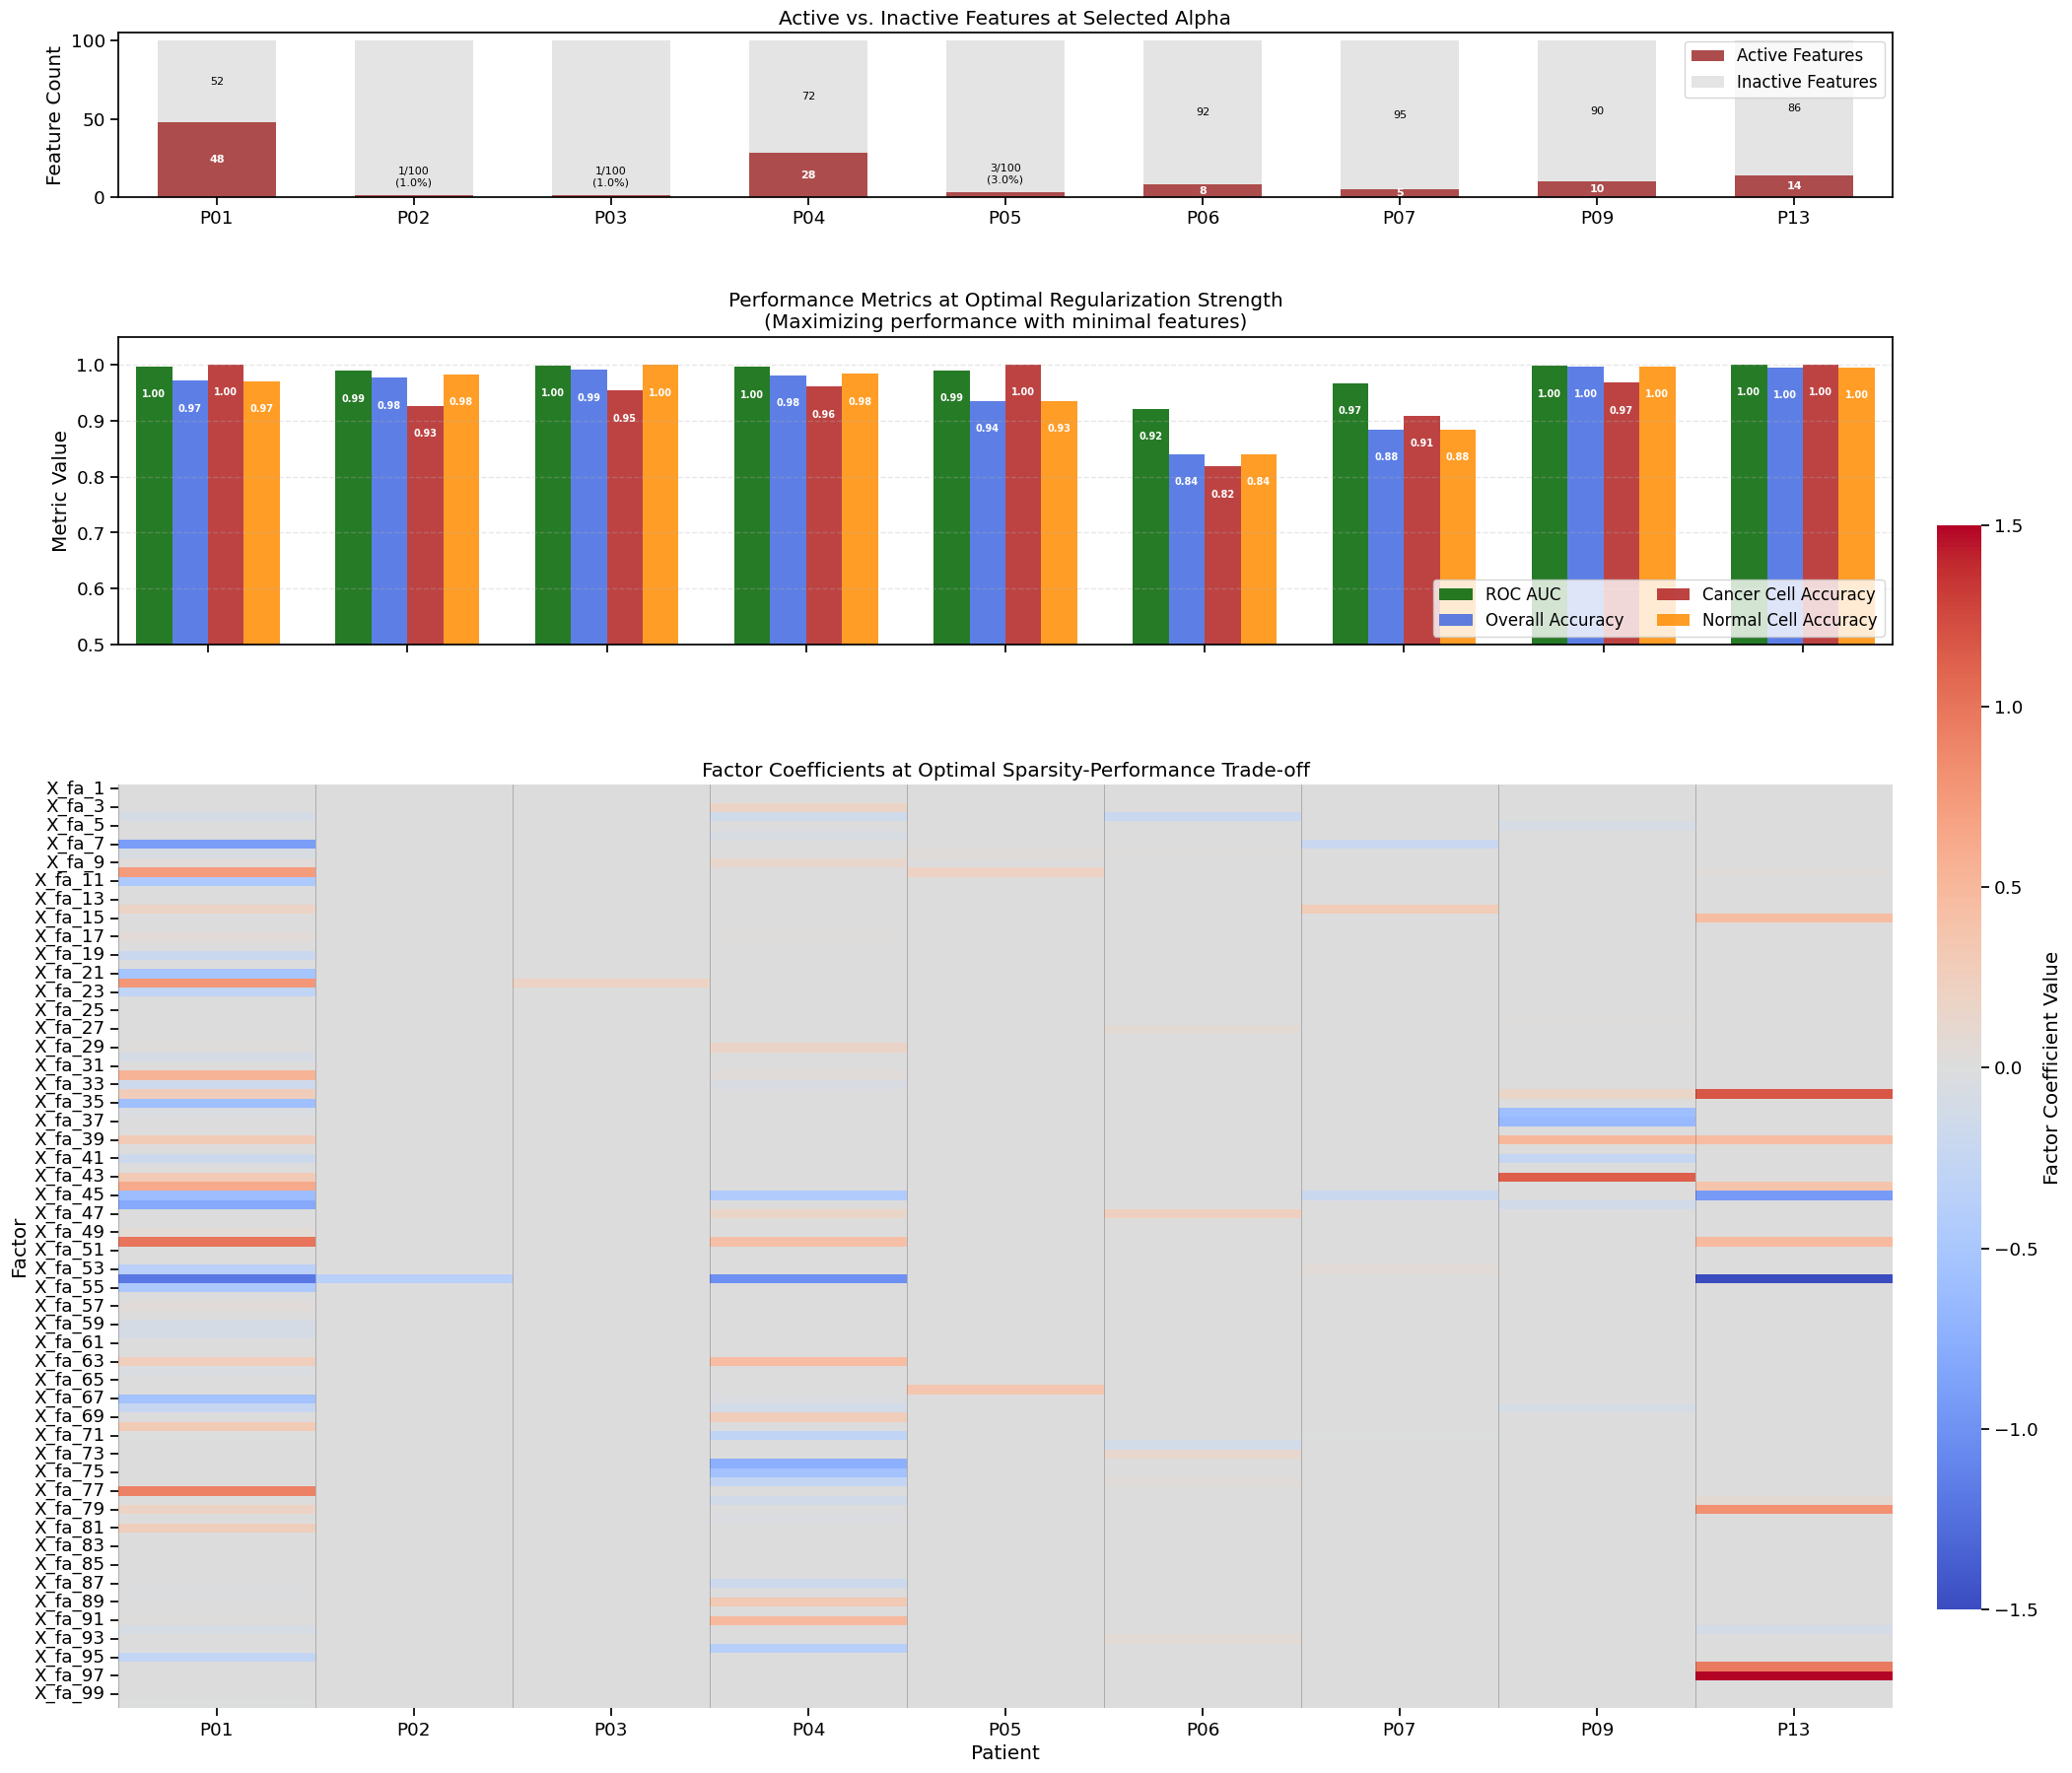

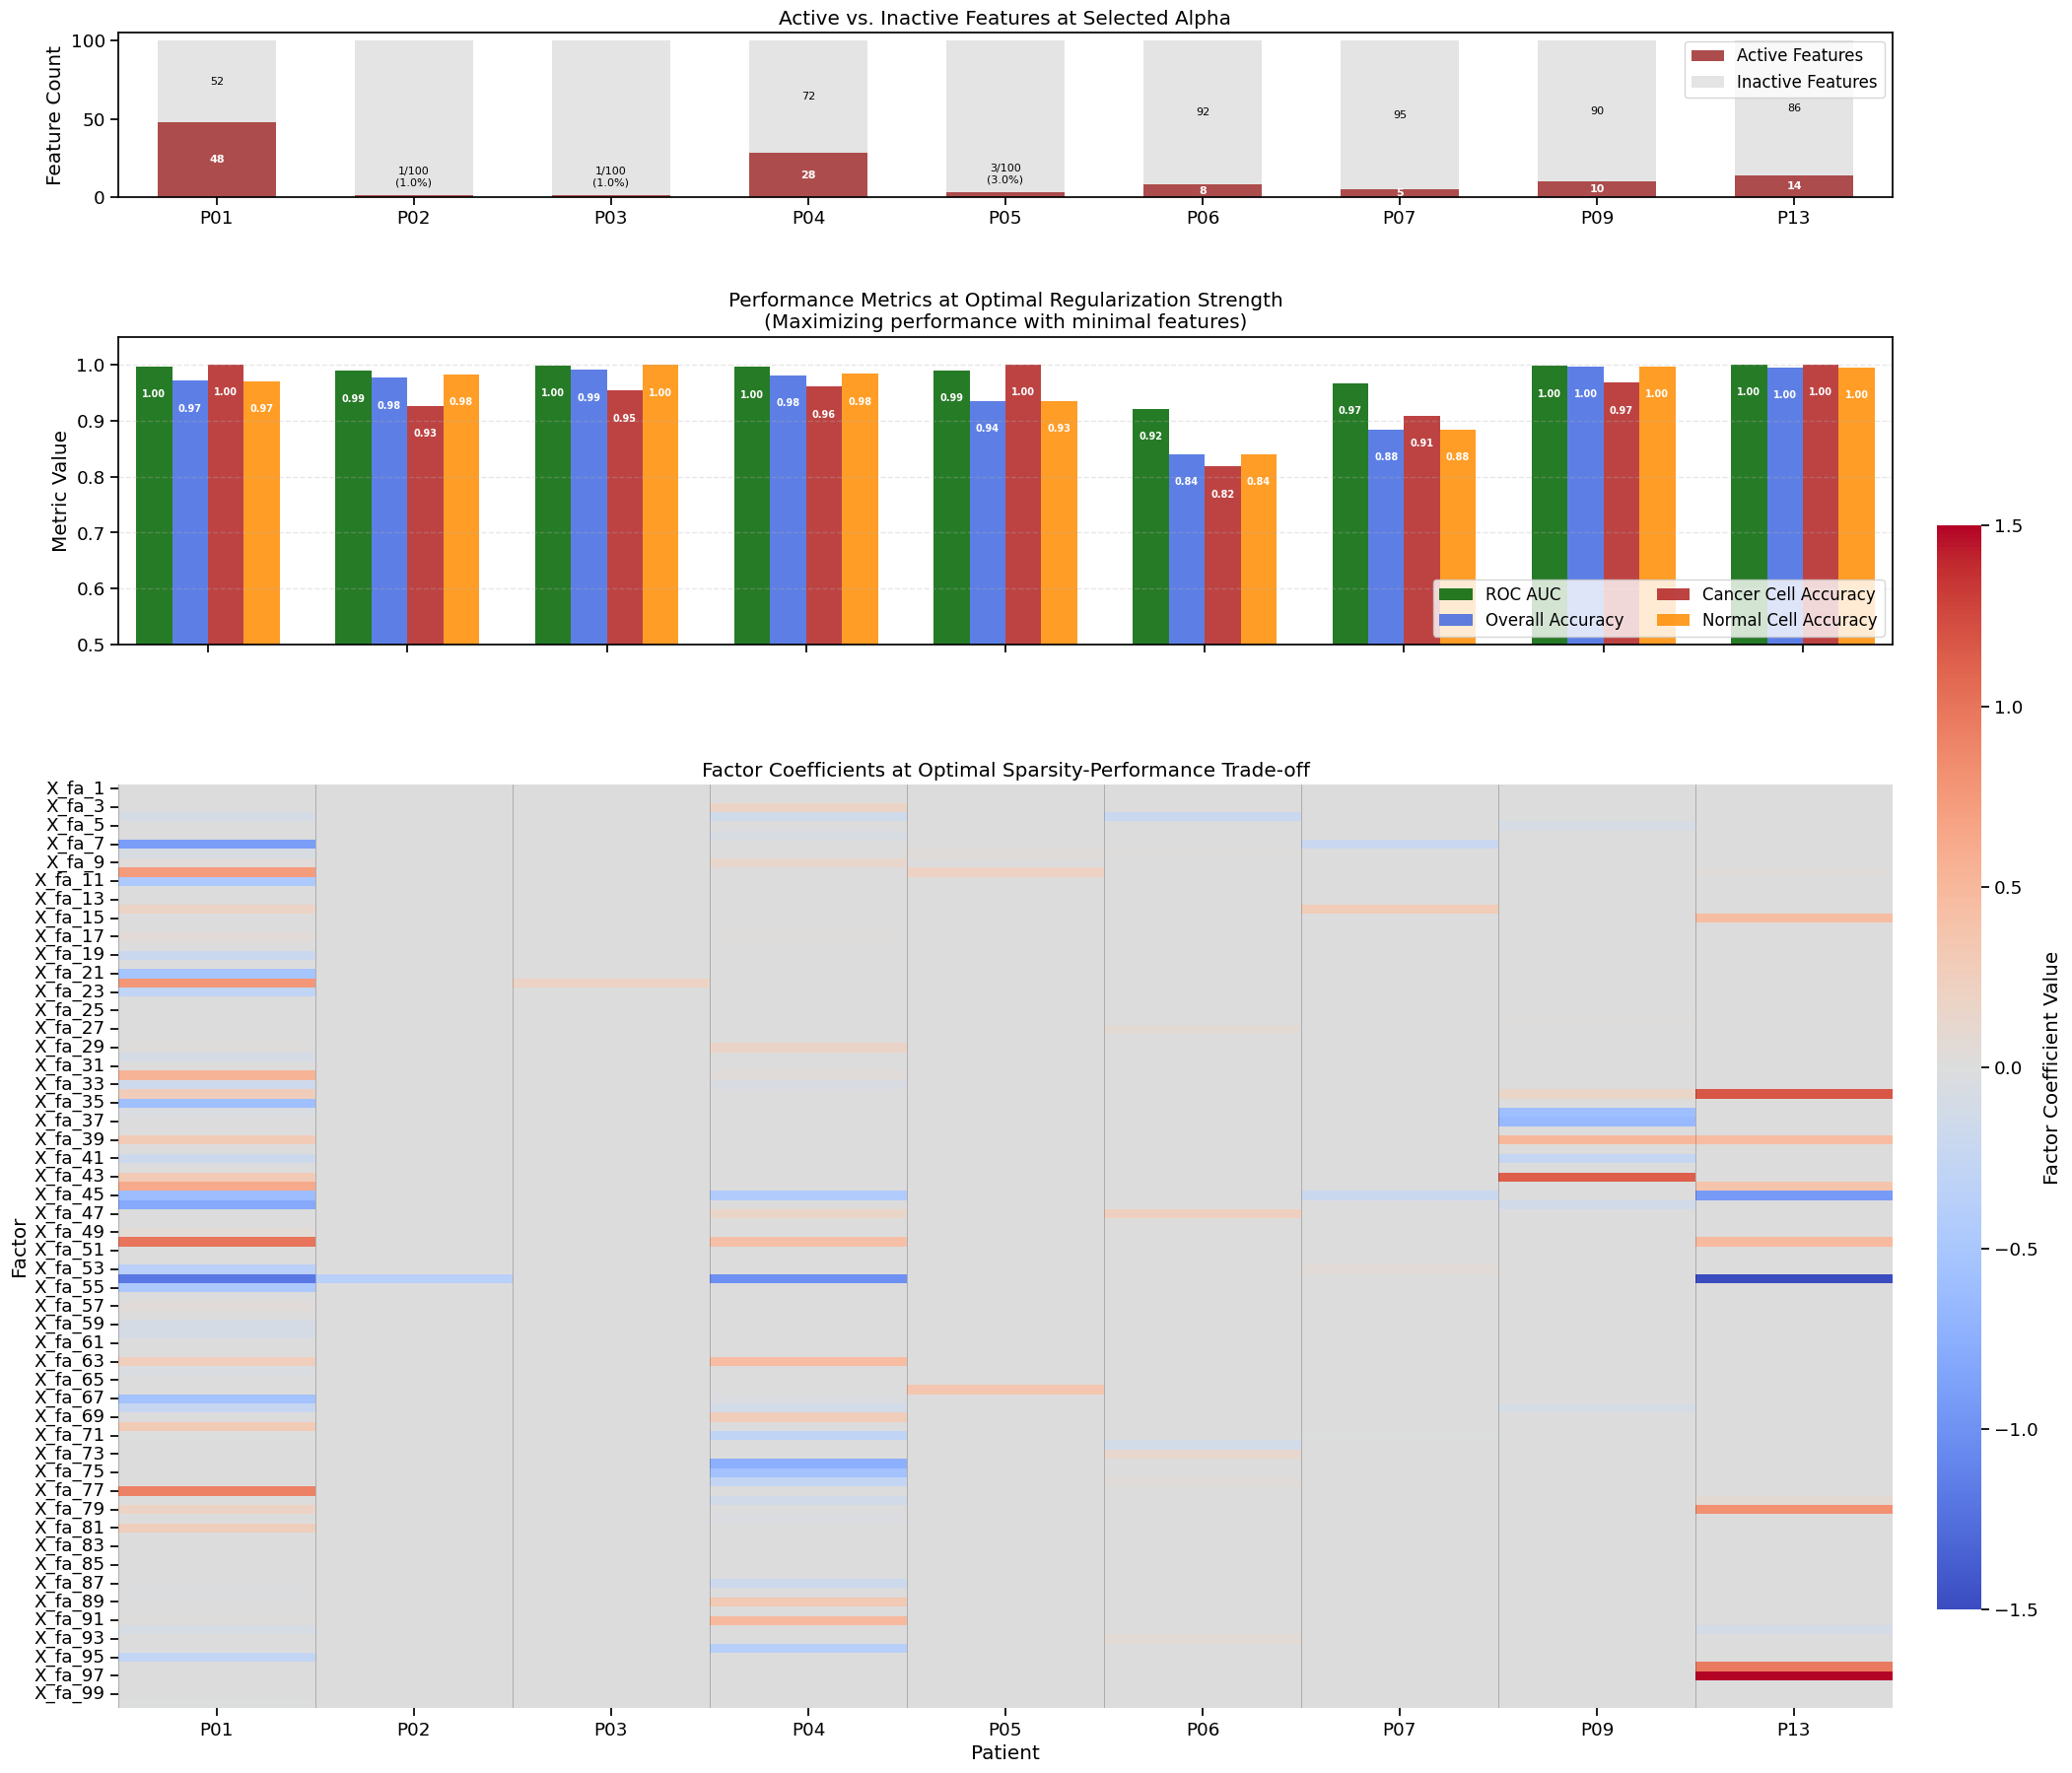

In [89]:
create_enhanced_plot(
    patient_metrics, 
    patient_coefficients, 
    hand_picked_alpha_indices, 
    alphas, 
    output_file="factor_coef_optimal_reg_strength_no_alpha_val.png"
)

In [21]:
def plot_confusion_matrices(metrics_df, sample_name="all_samples", n_cols=5):
    """
    Plot confusion matrices for a specific sample across all alphas as a heatmap grid.
    
    Parameters:
    - metrics_df: DataFrame containing metrics with TP, FP, TN, FN values
    - sample_name: Name of the sample to visualize
    - n_cols: Number of columns in the grid
    """
    # Filter metrics for the given sample
    sample_metrics = metrics_df[metrics_df['group'] == sample_name]
    
    if sample_metrics.empty:
        print(f"No metrics found for sample '{sample_name}'")
        return None
    
    # Extract confusion matrix components and alpha values
    alphas = sample_metrics['alpha'].values
    tp = sample_metrics['tp'].values
    fp = sample_metrics['fp'].values
    tn = sample_metrics['tn'].values
    fn = sample_metrics['fn'].values

    # Prepare the grid for heatmap subplots
    n_alphas = len(alphas)
    n_cols = min(n_alphas, n_cols)  # Number of columns in the grid
    n_rows = (n_alphas + n_cols - 1) // n_cols  # Calculate number of rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]  # Flatten the axes array for easy indexing

    # Plot each confusion matrix as a heatmap
    for i, alpha in enumerate(alphas):
        # Create the confusion matrix for the current alpha
        matrix = np.array([[tp[i], fp[i]], [fn[i], tn[i]]])
        
        # Create a heatmap
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
        axes[i].set_title(f"Alpha: {alpha:.2e}", fontsize=10)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
        axes[i].set_xticklabels(["Cancer", "Normal"], fontsize=8)
        axes[i].set_yticklabels(["Cancer", "Normal"], fontsize=8)

    # Hide unused axes in the grid
    for i in range(len(alphas), len(axes)):
        axes[i].axis("off")

    # Add a common title for the figure
    fig.suptitle(f"Confusion Matrices Across Alphas\nSample: {sample_name}", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()
    # return fig

#### Create a patient comparison plot

In [25]:
summary_file = os.path.join(per_patient_dir, "all_patient_summary.csv")
summary_df = pd.read_csv(summary_file)

In [28]:
summary_df['alpha']

0    0.0001
1    0.0001
2    0.0001
3    0.0001
4    0.0001
5    0.0001
6    0.0001
7    0.0001
8    0.0001
Name: alpha, dtype: float64

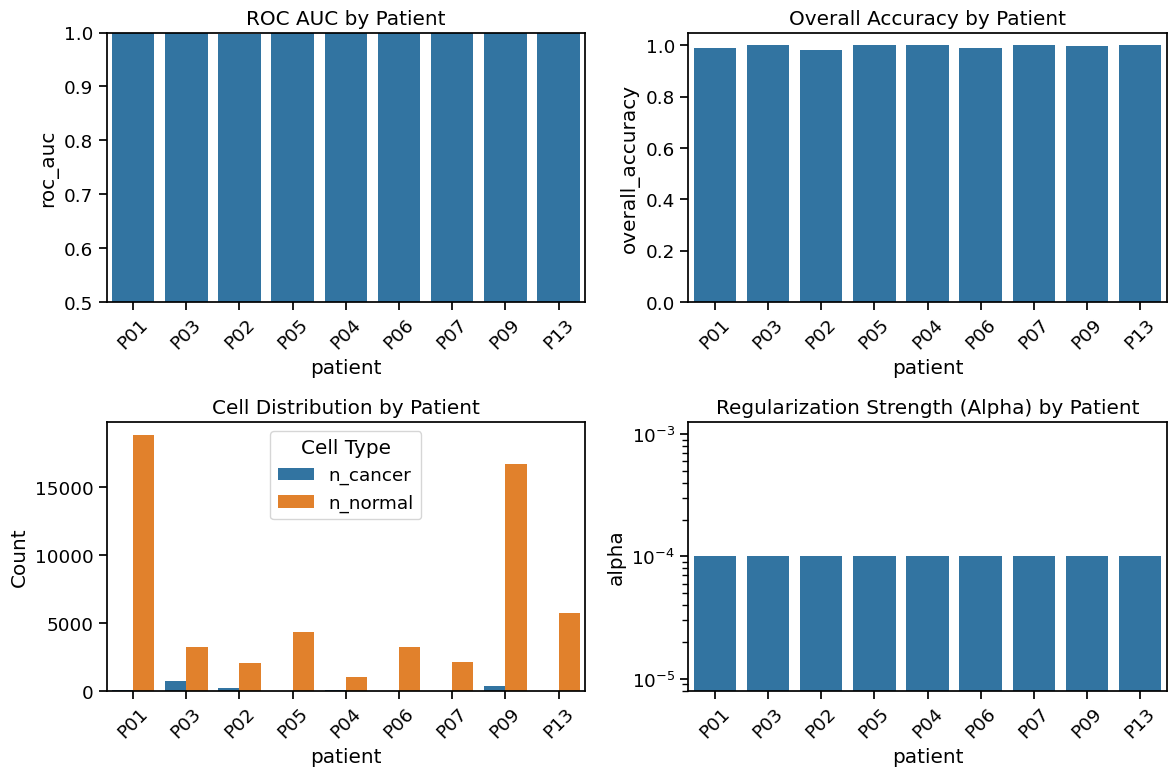

In [29]:
# Create comparison plots
plt.figure(figsize=(12, 8))

# Plot ROC AUC for each patient
if 'roc_auc' in summary_df.columns:
    plt.subplot(2, 2, 1)
    sns.barplot(x='patient', y='roc_auc', data=summary_df)
    plt.title('ROC AUC by Patient')
    plt.xticks(rotation=45)
    plt.ylim(0.5, 1.0)  # AUC range typically 0.5-1.0
    
# Plot overall accuracy
if 'overall_accuracy' in summary_df.columns:
    plt.subplot(2, 2, 2)
    sns.barplot(x='patient', y='overall_accuracy', data=summary_df)
    plt.title('Overall Accuracy by Patient')
    plt.xticks(rotation=45)
    
# Plot cancer vs normal cell counts
plt.subplot(2, 2, 3)
summary_melt = pd.melt(summary_df, id_vars=['patient'], value_vars=['n_cancer', 'n_normal'], 
                        var_name='Cell Type', value_name='Count')
sns.barplot(x='patient', y='Count', hue='Cell Type', data=summary_melt)
plt.title('Cell Distribution by Patient')
plt.xticks(rotation=45)

# Plot alpha values
if 'alpha' in summary_df.columns:
    plt.subplot(2, 2, 4)
    sns.barplot(x='patient', y='alpha', data=summary_df)
    plt.title('Regularization Strength (Alpha) by Patient')
    plt.yscale('log')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()